# 🚀 Optimisation Avancée du Modèle XGBoost
## Prédiction de Réponse aux Campagnes Marketing

**Objectif :** Améliorer la performance du modèle XGBoost en utilisant :
1. **GridSearchCV** pour l'optimisation des hyperparamètres
2. **SMOTE** pour le rééchantillonnage des données déséquilibrées
3. **SHAP values** pour l'interprétabilité avancée

**Baseline :** ROC-AUC = 0.8837, F1-Score = 0.5606

---

## 📦 Phase 1 : Imports et Chargement des Données

In [36]:
# Imports standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    f1_score,
    accuracy_score,
    make_scorer
)

# XGBoost
from xgboost import XGBClassifier

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("✅ Bibliothèques importées avec succès")
print(f"📅 Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Bibliothèques importées avec succès
📅 Date : 2025-10-17 11:51:44


In [37]:
# Installation des packages supplémentaires
import subprocess
import sys

packages = ['imbalanced-learn', 'shap']
for package in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', package, '--quiet'])
    
print("✅ Packages supplémentaires installés")

✅ Packages supplémentaires installés


In [38]:
# Import SMOTE et SHAP
from imblearn.over_sampling import SMOTE
import shap

print("✅ SMOTE et SHAP importés")

✅ SMOTE et SHAP importés


## 📊 Phase 2 : Préparation des Données

In [39]:
# Chargement du dataset
df = pd.read_csv('ML_DataSet.csv')

print("=" * 70)
print("CHARGEMENT DES DONNÉES")
print("=" * 70)
print(f"Shape : {df.shape}")
print(f"\nDistribution de la cible :")
print(df['Reponse_Derniere_Campagne'].value_counts())
print(f"\nRatio de déséquilibre : {df['Reponse_Derniere_Campagne'].value_counts()[0] / df['Reponse_Derniere_Campagne'].value_counts()[1]:.2f}:1")

CHARGEMENT DES DONNÉES
Shape : (2237, 49)

Distribution de la cible :
Reponse_Derniere_Campagne
0    1903
1     334
Name: count, dtype: int64

Ratio de déséquilibre : 5.70:1


In [40]:
# Sélection des features (même logique que ML_suivi.ipynb)
colonnes_a_exclure = [
    'ID_Client', 'Annee_Naissance', 'Date_Inscription',
    'Niveau_Education', 'Statut_Marital', 'Statut_Marital_Texte',
    'Jour_Inscription', 'Categorie_Age', 'Cout_Contact_Z',
    'Revenus_Z', 'Reponse_Derniere_Campagne',
    'Enfants_Maison', 'Ados_Maison'
]

X = df.drop(columns=colonnes_a_exclure)
y = df['Reponse_Derniere_Campagne']

print(f"\n✅ Features sélectionnées : {X.shape[1]} colonnes")
print(f"✅ Target : {y.shape[0]} lignes")


✅ Features sélectionnées : 36 colonnes
✅ Target : 2237 lignes


In [41]:
# Split Train/Test stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("=" * 70)
print("SPLIT TRAIN/TEST")
print("=" * 70)
print(f"X_train : {X_train.shape}")
print(f"X_test  : {X_test.shape}")
print(f"\nRatio train : {y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1")
print(f"Ratio test  : {y_test.value_counts()[0] / y_test.value_counts()[1]:.2f}:1")

SPLIT TRAIN/TEST
X_train : (1789, 36)
X_test  : (448, 36)

Ratio train : 5.70:1
Ratio test  : 5.69:1


In [42]:
# Gestion des valeurs manquantes
imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print(f"✅ Valeurs manquantes imputées")
print(f"   Train : {X_train.isnull().sum().sum()} NaN")
print(f"   Test  : {X_test.isnull().sum().sum()} NaN")

✅ Valeurs manquantes imputées
   Train : 0 NaN
   Test  : 0 NaN


In [43]:
# Calculer scale_pos_weight
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"\n✅ scale_pos_weight calculé : {scale_pos_weight:.2f}")


✅ scale_pos_weight calculé : 5.70


---
## 🎯 Phase 3 : Optimisation des Hyperparamètres (GridSearchCV)

### Fix pour compatibilité sklearn 1.6+ / XGBoost 1.7.6

In [44]:
# Wrapper pour rendre XGBoost 1.7.6 compatible avec scikit-learn 1.6+
from sklearn.base import BaseEstimator, ClassifierMixin

class XGBClassifierWrapper(BaseEstimator, ClassifierMixin):
    """Wrapper pour XGBoost 1.7.6 compatible avec sklearn 1.6+"""
    
    def __init__(self, n_estimators=100, max_depth=3, learning_rate=0.1, 
                 gamma=0, subsample=1.0, scale_pos_weight=1, random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.subsample = subsample
        self.scale_pos_weight = scale_pos_weight
        self.random_state = random_state
        self._estimator = None
        
    def fit(self, X, y):
        self._estimator = XGBClassifier(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            learning_rate=self.learning_rate,
            gamma=self.gamma,
            subsample=self.subsample,
            scale_pos_weight=self.scale_pos_weight,
            random_state=self.random_state,
            eval_metric='logloss'
        )
        self._estimator.fit(X, y)
        self.classes_ = self._estimator.classes_
        return self
        
    def predict(self, X):
        return self._estimator.predict(X)
        
    def predict_proba(self, X):
        return self._estimator.predict_proba(X)
    
    @property
    def feature_importances_(self):
        return self._estimator.feature_importances_

print("=" * 70)
print("🔍 OPTIMISATION DES HYPERPARAMÈTRES - GRIDSEARCHCV")
print("=" * 70)
print("\n✅ Wrapper XGBoost créé pour compatibilité sklearn 1.6+")

# Grille de paramètres (version RAPIDE)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.3],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0]
}

print(f"\n📋 Grille de paramètres :")
for param, values in param_grid.items():
    print(f"   {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\n🔢 Nombre total de combinaisons : {total_combinations}")
print(f"⏱️  Temps estimé : ~{total_combinations * 0.5:.1f} minutes (avec 3-fold CV)")

# Modèle de base
xgb_base = XGBClassifierWrapper(
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

# GridSearchCV
f1_scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("\n🚀 Configuration terminée. Prêt pour l'entraînement.")

🔍 OPTIMISATION DES HYPERPARAMÈTRES - GRIDSEARCHCV

✅ Wrapper XGBoost créé pour compatibilité sklearn 1.6+

📋 Grille de paramètres :
   n_estimators: [100, 200]
   max_depth: [3, 5]
   learning_rate: [0.1, 0.3]
   gamma: [0, 0.1]
   subsample: [0.8, 1.0]

🔢 Nombre total de combinaisons : 32
⏱️  Temps estimé : ~16.0 minutes (avec 3-fold CV)

🚀 Configuration terminée. Prêt pour l'entraînement.


In [45]:
# Entraînement avec GridSearchCV
import time

print("\n⏳ Lancement de GridSearchCV (cela peut prendre 10-15 minutes)...\n")
start_time = time.time()

grid_search.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"\n✅ GridSearchCV terminé en {elapsed_time/60:.2f} minutes")


⏳ Lancement de GridSearchCV (cela peut prendre 10-15 minutes)...

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_esti

In [46]:
# Afficher les meilleurs paramètres
print("=" * 70)
print("🏆 MEILLEURS HYPERPARAMÈTRES TROUVÉS")
print("=" * 70)
print(f"\nMeilleur score F1 (CV) : {grid_search.best_score_:.4f}\n")
print("Paramètres optimaux :")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

# Récupérer le vrai XGBoost depuis le wrapper
best_xgb = grid_search.best_estimator_._estimator
print("\n✅ Meilleur modèle extrait du wrapper")

🏆 MEILLEURS HYPERPARAMÈTRES TROUVÉS

Meilleur score F1 (CV) : 0.5741

Paramètres optimaux :
   gamma: 0.1
   learning_rate: 0.1
   max_depth: 3
   n_estimators: 200
   subsample: 0.8

✅ Meilleur modèle extrait du wrapper


In [47]:
# Évaluer le modèle optimisé sur X_test
y_pred_optimized = best_xgb.predict(X_test)
y_pred_proba_optimized = best_xgb.predict_proba(X_test)[:, 1]

accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
f1_optimized = f1_score(y_test, y_pred_optimized)
roc_auc_optimized = roc_auc_score(y_test, y_pred_proba_optimized)

print("\n" + "=" * 70)
print("📊 PERFORMANCES DU MODÈLE OPTIMISÉ (GridSearchCV)")
print("=" * 70)
print(f"\nAccuracy  : {accuracy_optimized:.4f}")
print(f"F1-Score  : {f1_optimized:.4f}")
print(f"ROC-AUC   : {roc_auc_optimized:.4f}")
print("\n📋 Rapport de Classification :")
print(classification_report(y_test, y_pred_optimized, target_names=['Non (0)', 'Oui (1)']))


📊 PERFORMANCES DU MODÈLE OPTIMISÉ (GridSearchCV)

Accuracy  : 0.8772
F1-Score  : 0.6259
ROC-AUC   : 0.8947

📋 Rapport de Classification :
              precision    recall  f1-score   support

     Non (0)       0.94      0.91      0.93       381
     Oui (1)       0.57      0.69      0.63        67

    accuracy                           0.88       448
   macro avg       0.76      0.80      0.78       448
weighted avg       0.89      0.88      0.88       448



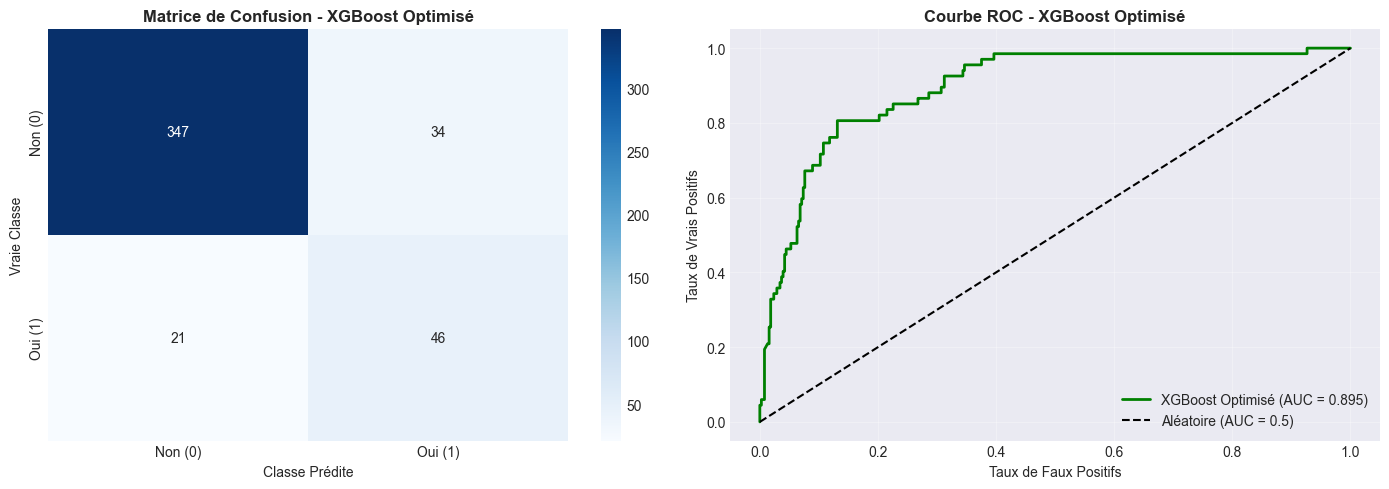

In [48]:
# Visualisation : Matrice de confusion et Courbe ROC
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_optimized)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Non (0)', 'Oui (1)'],
            yticklabels=['Non (0)', 'Oui (1)'])
axes[0].set_title('Matrice de Confusion - XGBoost Optimisé', fontweight='bold')
axes[0].set_ylabel('Vraie Classe')
axes[0].set_xlabel('Classe Prédite')

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_optimized)
axes[1].plot(fpr, tpr, label=f'XGBoost Optimisé (AUC = {roc_auc_optimized:.3f})', linewidth=2, color='green')
axes[1].plot([0, 1], [0, 1], 'k--', label='Aléatoire (AUC = 0.5)')
axes[1].set_xlabel('Taux de Faux Positifs')
axes[1].set_ylabel('Taux de Vrais Positifs')
axes[1].set_title('Courbe ROC - XGBoost Optimisé', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 🔄 Phase 4 : Comparaison avec SMOTE

### Objectif : Tester le rééquilibrage par suréchantillonnage

In [49]:
print("=" * 70)
print("🔄 APPLICATION DE SMOTE (Suréchantillonnage)")
print("=" * 70)

# Appliquer SMOTE sur train set uniquement
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\nAvant SMOTE :")
print(f"   Shape : {X_train.shape}")
print(f"   Distribution : {y_train.value_counts().to_dict()}")

print(f"\nAprès SMOTE :")
print(f"   Shape : {X_train_smote.shape}")
print(f"   Distribution : {y_train_smote.value_counts().to_dict()}")
print(f"\n✅ Dataset rééquilibré (50/50)")

🔄 APPLICATION DE SMOTE (Suréchantillonnage)

Avant SMOTE :
   Shape : (1789, 36)
   Distribution : {0: 1522, 1: 267}

Après SMOTE :
   Shape : (3044, 36)
   Distribution : {0: 1522, 1: 1522}

✅ Dataset rééquilibré (50/50)


In [50]:
# Entraîner XGBoost avec meilleurs params + SMOTE
print("\n🚀 Entraînement de XGBoost avec SMOTE...")

xgb_smote = XGBClassifier(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    learning_rate=grid_search.best_params_['learning_rate'],
    gamma=grid_search.best_params_['gamma'],
    subsample=grid_search.best_params_['subsample'],
    scale_pos_weight=1,  # Pas besoin avec SMOTE
    random_state=42,
    eval_metric='logloss'
)

xgb_smote.fit(X_train_smote, y_train_smote)
print("✅ Modèle entraîné avec SMOTE")


🚀 Entraînement de XGBoost avec SMOTE...
✅ Modèle entraîné avec SMOTE


In [51]:
# Évaluer le modèle avec SMOTE
y_pred_smote = xgb_smote.predict(X_test)
y_pred_proba_smote = xgb_smote.predict_proba(X_test)[:, 1]

accuracy_smote = accuracy_score(y_test, y_pred_smote)
f1_smote = f1_score(y_test, y_pred_smote)
roc_auc_smote = roc_auc_score(y_test, y_pred_proba_smote)

print("=" * 70)
print("📊 PERFORMANCES DU MODÈLE AVEC SMOTE")
print("=" * 70)
print(f"\nAccuracy  : {accuracy_smote:.4f}")
print(f"F1-Score  : {f1_smote:.4f}")
print(f"ROC-AUC   : {roc_auc_smote:.4f}")
print("\n📋 Rapport de Classification :")
print(classification_report(y_test, y_pred_smote, target_names=['Non (0)', 'Oui (1)']))

📊 PERFORMANCES DU MODÈLE AVEC SMOTE

Accuracy  : 0.8772
F1-Score  : 0.5217
ROC-AUC   : 0.8903

📋 Rapport de Classification :
              precision    recall  f1-score   support

     Non (0)       0.91      0.95      0.93       381
     Oui (1)       0.62      0.45      0.52        67

    accuracy                           0.88       448
   macro avg       0.77      0.70      0.73       448
weighted avg       0.87      0.88      0.87       448



---
## 📊 Phase 5 : Comparaison Finale

In [52]:
print("=" * 70)
print("📊 COMPARAISON : scale_pos_weight vs SMOTE")
print("=" * 70)

comparaison = pd.DataFrame({
    'Approche': ['scale_pos_weight', 'SMOTE'],
    'Accuracy': [accuracy_optimized, accuracy_smote],
    'F1-Score': [f1_optimized, f1_smote],
    'ROC-AUC': [roc_auc_optimized, roc_auc_smote]
}).round(4)

print("\n")
print(comparaison.to_string(index=False))

best_idx = comparaison['ROC-AUC'].idxmax()
best_approach = comparaison.loc[best_idx, 'Approche']
best_auc = comparaison.loc[best_idx, 'ROC-AUC']
best_f1 = comparaison.loc[best_idx, 'F1-Score']

print("\n" + "=" * 70)
print(f"🏆 CHAMPION : {best_approach}")
print(f"   ROC-AUC : {best_auc:.4f}")
print(f"   F1-Score : {best_f1:.4f}")
print("=" * 70)

📊 COMPARAISON : scale_pos_weight vs SMOTE


        Approche  Accuracy  F1-Score  ROC-AUC
scale_pos_weight    0.8772    0.6259   0.8947
           SMOTE    0.8772    0.5217   0.8903

🏆 CHAMPION : scale_pos_weight
   ROC-AUC : 0.8947
   F1-Score : 0.6259


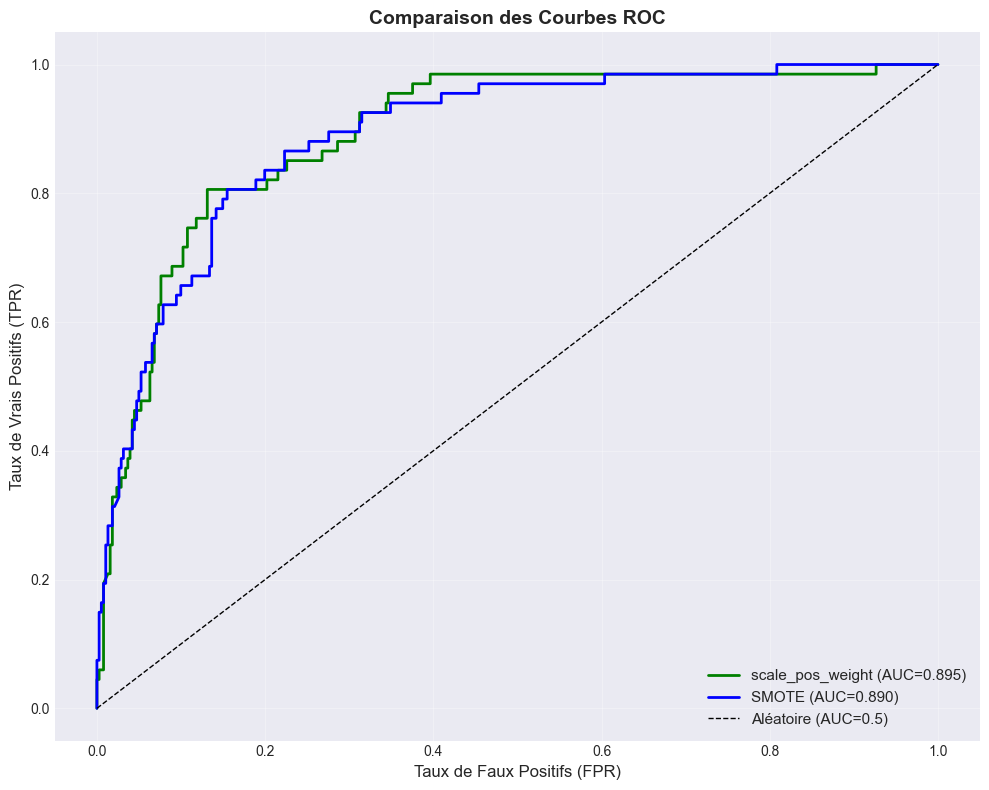

In [53]:
# Courbes ROC comparées
plt.figure(figsize=(10, 8))

fpr_opt, tpr_opt, _ = roc_curve(y_test, y_pred_proba_optimized)
plt.plot(fpr_opt, tpr_opt, label=f'scale_pos_weight (AUC={roc_auc_optimized:.3f})', linewidth=2, color='green')

fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred_proba_smote)
plt.plot(fpr_smote, tpr_smote, label=f'SMOTE (AUC={roc_auc_smote:.3f})', linewidth=2, color='blue')

plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire (AUC=0.5)', linewidth=1)
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('Comparaison des Courbes ROC', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 🔍 Phase 6 : Interprétabilité avec SHAP Values

In [54]:
print("=" * 70)
print("🔍 ANALYSE SHAP - Interprétabilité Avancée")
print("=" * 70)
print("\n⏳ Calcul des SHAP values (1-2 minutes)...\n")

# Choisir le modèle champion
if roc_auc_optimized >= roc_auc_smote:
    model_champion = best_xgb
    model_name = "XGBoost (scale_pos_weight)"
else:
    model_champion = xgb_smote
    model_name = "XGBoost (SMOTE)"

print(f"🏆 Modèle analysé : {model_name}")

🔍 ANALYSE SHAP - Interprétabilité Avancée

⏳ Calcul des SHAP values (1-2 minutes)...

🏆 Modèle analysé : XGBoost (scale_pos_weight)


In [55]:
# Calculer SHAP values
explainer = shap.TreeExplainer(model_champion)

sample_size = min(200, len(X_test))
X_test_sample = X_test.sample(n=sample_size, random_state=42)

shap_values = explainer.shap_values(X_test_sample)
print(f"\n✅ SHAP values calculées pour {sample_size} échantillons")


✅ SHAP values calculées pour 200 échantillons



📊 SHAP Summary Plot



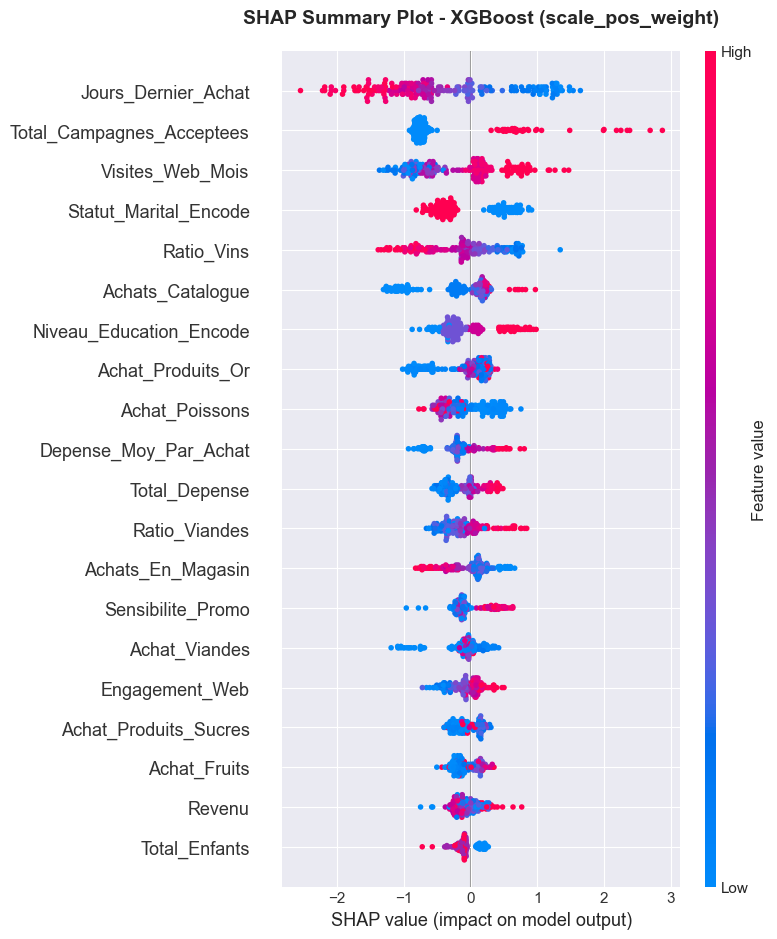

In [56]:
# SHAP Summary Plot
print("\n📊 SHAP Summary Plot\n")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title(f'SHAP Summary Plot - {model_name}', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


📊 SHAP Feature Importance (Top 10)



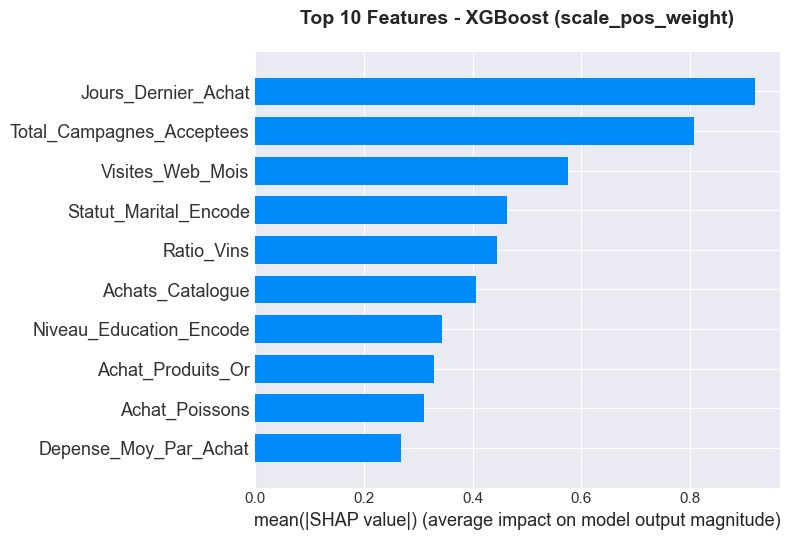

In [57]:
# SHAP Feature Importance
print("\n📊 SHAP Feature Importance (Top 10)\n")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False, max_display=10)
plt.title(f'Top 10 Features - {model_name}', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [58]:
# Top 5 Features avec interprétation
shap_importance = pd.DataFrame({
    'Feature': X_test_sample.columns,
    'SHAP_Importance': np.abs(shap_values).mean(axis=0)
}).sort_values('SHAP_Importance', ascending=False)

print("=" * 70)
print("🎯 TOP 5 FEATURES - SHAP Values")
print("=" * 70)
print(shap_importance.head(5).to_string(index=False))
print("\n💡 Ces features ont le plus d'impact sur les prédictions")

🎯 TOP 5 FEATURES - SHAP Values
                  Feature  SHAP_Importance
      Jours_Dernier_Achat         0.918538
Total_Campagnes_Acceptees         0.806358
         Visites_Web_Mois         0.574549
    Statut_Marital_Encode         0.462522
               Ratio_Vins         0.444783

💡 Ces features ont le plus d'impact sur les prédictions


---
## 📝 Phase 7 : Conclusions

In [59]:
print("=" * 70)
print("📝 CONCLUSIONS FINALES")
print("=" * 70)

print(f"\n🏆 CHAMPION : {best_approach}")
print(f"   ROC-AUC  : {best_auc:.4f}")
print(f"   F1-Score : {best_f1:.4f}")

baseline_auc = 0.8837
baseline_f1 = 0.5606
improvement_auc = ((best_auc - baseline_auc) / baseline_auc) * 100
improvement_f1 = ((best_f1 - baseline_f1) / baseline_f1) * 100

print("\n📊 AMÉLIORATION vs BASELINE :")
print(f"   ROC-AUC  : {baseline_auc:.4f} → {best_auc:.4f} ({improvement_auc:+.2f}%)")
print(f"   F1-Score : {baseline_f1:.4f} → {best_f1:.4f} ({improvement_f1:+.2f}%)")

print("\n✅ Optimisation terminée avec succès !")
print(f"📅 {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 70)

📝 CONCLUSIONS FINALES

🏆 CHAMPION : scale_pos_weight
   ROC-AUC  : 0.8947
   F1-Score : 0.6259

📊 AMÉLIORATION vs BASELINE :
   ROC-AUC  : 0.8837 → 0.8947 (+1.24%)
   F1-Score : 0.5606 → 0.6259 (+11.65%)

✅ Optimisation terminée avec succès !
📅 2025-10-17 11:51:50


In [60]:
# Sauvegarder le modèle champion
import joblib

model_filename = 'xgboost_champion_optimized.pkl'
joblib.dump(model_champion, model_filename)
print(f"\n💾 Modèle champion sauvegardé : {model_filename}")


💾 Modèle champion sauvegardé : xgboost_champion_optimized.pkl
